# Keras ConvLSTM2D network

Use a network made of convolutional LSTM layers.

In [20]:
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import *
import keras.backend as K
import imageio
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

import sys
sys.path.append('..')
import SequenceLineFilterLayer

modelPath = 'model/LSTMCategoricalV2.h5'

## Model

## Data

Full games are represented as image sequences ("movies"). The network has to predict the next frame of an unfinished sequence.

The input data is the full game without the last state where all lines are filled in. The output data is the full game without the very first state where no lines are drawn.

In [3]:
sequenceDataset = np.load('LSTM-5x4.npz')
games = sequenceDataset['games']
print(games.shape)

(50000, 49, 11, 13)


In [5]:
SequenceLineFilterLayer.SequenceLineFilterLayer.imgWidth = games.shape[-1]
SequenceLineFilterLayer.SequenceLineFilterLayer.imgHeight = games.shape[-2]
model = load_model(modelPath, custom_objects={'SequenceLineFilterLayer':SequenceLineFilterLayer.SequenceLineFilterLayer})

LineFilterLayer from_config!
using static image size 13 x 11


In [12]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   input_shape=(None, None, None, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(5,5,5), padding='same'))

seq.add(SequenceLineFilterLayer.SequenceLineFilterLayer(games.shape[-1], games.shape[-2], noShapeCheck=True))

seq.add(Activation('softmax'))

seq.compile(loss='categorical_crossentropy', optimizer='adadelta')

model = seq
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, None, None,  164160    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, None, None,  320160    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, None, None,  320160    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, None, None,  320160    
__________

In [13]:
for layer in model.layers:
    print(layer.output_shape)

(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 1)
(None, None, None)
(None, None, None)


In [14]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

lineFilterMatrixNP(13,11)

array([[False, False, False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False,  True, False,  True, False,  True, False,  True, False,  True,
        False, False],
       [False,  True, False,  True, False,  True, False,  True, False,  True, False,
         True, False],
       [False, False,  True, False,  True, False,  True, False,  True, False,  True,
        False, False],
       [False,  True, False,  True, False,  True, False,  True, False,  True, False,
         True, False],
       [False, False,  True, False,  True, False,  True, False,  True, False,  True,
        False, False],
       [False,  True, False,  True, False,  True, False,  True, False,  True, False,
         True, False],
       [False, False,  True, False,  True, False,  True, False,  True, False,  True,
        False, False],
       [False,  True, False,  True, False,  True, False,  True, False,  True, False,
         True, False],
       [False, False,  True,

In [15]:
x_train = games[:,:-1,:,:]
y_train = np.subtract(games[:,0:-1,:,:], games[:,1:,:,:])[:,:,lineFilterMatrixNP(x_train.shape[-1], x_train.shape[-2])]
print(x_train.shape)
print(y_train.shape)

x_train = x_train.astype(K.floatx())
y_train = y_train.astype(K.floatx())
x_train /= 255
#y_train /= 255

np.set_printoptions(precision=2, suppress=True, linewidth=90)

print(x_train[23,10])
print(y_train[23,10])
print(np.subtract(games[23,10:-1,:,:], games[23,11:,:,:])[10])


(50000, 48, 11, 13)
(50000, 48, 49)
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 1.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 1.   0.84 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 1.   0.84 1.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0

In [16]:

exampleGameIdx = 23
exampleGameFrame = 10

print(x_train[exampleGameIdx,exampleGameFrame])
print(y_train[exampleGameIdx,exampleGameFrame])

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 1.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 1.   0.84 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 1.   0.84 1.   0.84 0.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [17]:
x_train = x_train.reshape(x_train.shape + (1,))
print(x_train.shape)

(50000, 48, 11, 13, 1)


## Training

In [23]:
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

model.fit(x_train, y_train, callbacks=callbacks, batch_size=20, epochs=2, validation_split=0.05)
model.save(modelPath)

Train on 47500 samples, validate on 2500 samples
Epoch 1/2
Epoch 1/2
47500/47500 [==============================] - 4813s 101ms/step - loss: 0.0661 - val_loss: 1.5110e-06
Epoch 2/2
Epoch 2/2
47500/47500 [==============================] - 4838s 102ms/step - loss: 9.3309e-07 - val_loss: 6.4875e-07


In [24]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

sample 12143
(1, 32, 49)
(49,)
(11, 13)
input:
(50000, 48, 11, 13, 1)
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.84 1.   0.84 1.   0.84 0.   0.84 1.   0.84 1.   0.84 0.  ]
 [0.   1.   0.25 1.   0.25 1.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.84 1.   0.84 1.   0.84 0.   0.84 0.   0.84 1.   0.84 0.  ]
 [0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.  ]
 [0.   0.84 0.   0.84 0.   0.84 1.   0.84 1.   0.84 0.   0.84 0.  ]
 [0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.84 1.   0.84 1.   0.84 0.   0.84 1.   0.84 1.   0.84 0.  ]
 [0.   1.   0.59 1.   0.59 1.   0.   0.   0.   1.   0.59 1.   0.  ]
 [0.   0.84 1.   0.84 1.   0.84 1.   0.84 0.   0.84 1.   0.84 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
prediction:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.  ]
 [0.   0.45 0.   0.   0.   0.   0

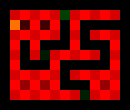

In [28]:
example = random.randrange(x_train.shape[0])
print("sample " + str(example))
exampleFrame = 32
input_data = np.array([x_train[example,0:exampleFrame,::,::,::]])
prediction = model.predict(input_data)
print(prediction.shape)
prediction = prediction[0, -1, ::]
print(prediction.shape)
prediction = linesToDotsAndBoxesImage(prediction, x_train.shape[-2], x_train.shape[-3])
print(prediction.shape)

print("input:")
print(x_train.shape)
print(x_train[example,exampleFrame,::,::,0])

print("prediction:")
print(prediction)

# create image
target_imgdata = x_train[example,exampleFrame,::,::,0] * 255
target_imgdata = target_imgdata.astype(np.uint8)

prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros(prediction.shape, dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata, tmp], axis=2)
merged_imgdata_large = np.append(target_imgdata, prediction_imgdata, axis=1)
print(merged_imgdata.shape)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
#img = Image.fromarray(merged_imgdata_large, 'P')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img

In [ ]:
target_imgdata = x_train[example,:,:,0] * 255
target_imgdata = target_imgdata.astype(np.uint8)

prediction_imgdata = prediction[0] * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction[0].shape[0], prediction[0].shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata[:,:,1], tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img